In [1]:
###Create the data (normalized to [-1,1] and zero mean)
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
X,y = make_moons(200,noise=0.1)
X=X-np.mean(X,axis=0)

Text(0, 0.5, 'x1')

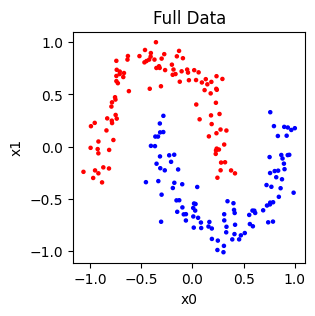

In [2]:
###Plot all the data
from matplotlib.colors import BoundaryNorm,ListedColormap
cmap = ListedColormap(['red', 'blue'])
plt.figure(figsize=(3,3))
plt.scatter(X[:, 0], X[:, 1], s= 5, c=y, cmap=cmap)
plt.title('Full Data')
plt.xlabel("x0")
plt.ylabel("x1")

Training Data:
Plus: 50
Minus: 50
------------
Test Data:
Plus: 50
Minus: 50


[Text(0.5, 0, 'x0'), Text(0, 0.5, 'x1'), Text(0.5, 1.0, 'Test Data')]

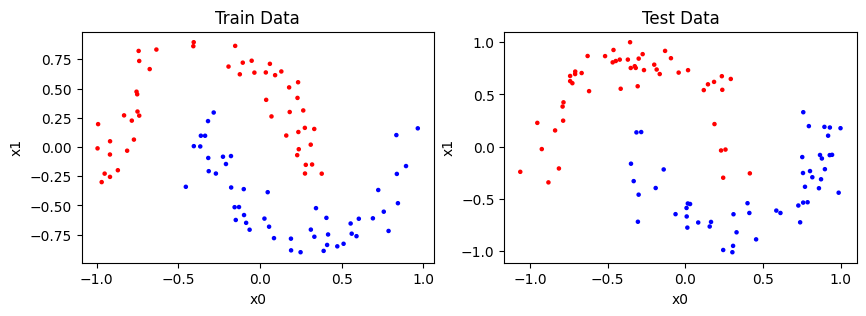

In [3]:
###Test train split
plus = [X[i] for i in range(len(y)) if y[i]==1]
minus = [X[i] for i in range(len(y)) if y[i]==0]

np.random.shuffle(plus)
np.random.shuffle(minus)

train_x,train_y = np.array(plus[:50]+minus[:50]), np.array([1]*50 + [-1]*50)
test_x,test_y = np.array(plus[50:100]+minus[50:100]), np.array([1]*50 + [-1]*50)

l=np.array(range(100))
np.random.shuffle(l)
train_x = train_x[l,:]
test_x = test_x[l,:]
train_y = train_y[l]
test_y = test_y[l]

print("Training Data:")
print("Plus: "+str(len([i for i in train_y if i==1])))
print("Minus: "+str(len([i for i in train_y if i==-1])))
print("------------")
print("Test Data:")
print("Plus: "+str(len([i for i in test_y if i==1])))
print("Minus: "+str(len([i for i in test_y if i==-1])))


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,3))
ax1.scatter(train_x[:, 0], train_x[:, 1], s= 5, c=train_y, cmap=cmap)
ax2.scatter(test_x[:, 0], test_x[:, 1], s= 5, c=test_y, cmap=cmap)
ax1.set(xlabel='x0',
    ylabel='x1',
    title='Train Data')
ax2.set(xlabel='x0',
    ylabel='x1',
    title='Test Data')

In [4]:
###Functions to work with circuits
from circuits import *

In [5]:
from qiskit.quantum_info import Statevector
def clifford_kernel(encoder,x,y):
    '''
    Compute the weak kernel function
    
    (Quantum Circuit) encoder: Feature map circuit
    (Iterable[Float]) x: first data point
    (Iterable[Float]) y: second data point
    
    Returns: 
    (Float) Weak kernel function value
    '''
    qc_x = Cliffordize(encoder.assign_parameters(x[:encoder.num_parameters]))
    qc_y = Cliffordize(encoder.assign_parameters(y[:encoder.num_parameters]))
    
    return abs(Statevector(qc_x).inner(Statevector(qc_y)))**2

def get_clifford_kernel(encoder):
    '''
    Kernel method for sklearn SVC
    '''
    def clifford_kernel_matrix(A, B):
        return np.array([[clifford_kernel(encoder,a, b) for b in B] for a in A])
    return clifford_kernel_matrix

def exact_kernel(encoder,x,y):
    '''
    Compute the exact kernel function
    
    (Quantum Circuit) encoder: Feature map circuit
    (Iterable[Float]) x: first data point
    (Iterable[Float]) y: second data point
    
    Returns: 
    (Float) Kernel function value
    '''
    qc_x = (encoder.assign_parameters(x[:encoder.num_parameters]))
    qc_y = (encoder.assign_parameters(y[:encoder.num_parameters]))
    s_x=Statevector(qc_x)
    s_y=Statevector(qc_y)
    return np.abs(s_x.inner(s_y))**2

def get_exact_kernel(encoder):
    '''
    Kernel method for sklearn SVC
    '''
    def kernel_matrix(A, B):
        return np.array([[exact_kernel(encoder,a, b) for b in B] for a in A])
    return kernel_matrix

def clifford_kernel_matrix(encoder,A):
    '''
    Compute the (weak) kernel matrix of data with itself. Faster because of symmetry
    
    (Quantum Circuit) encoder: Feature map circuit
    (Iterable[Iterable[Float]]) x: data

    Returns: 
    (Iterable[Iterable[Float]]) Weak kernel matrix
    '''
    K = np.identity(len(A))
    for i in range(0,len(A)):
        for j in range(i+1,len(A)):
            v=clifford_kernel(encoder,A[i], A[j])
            K[i][j],K[j][i]=v,v
    return K


In [6]:
M=3  ### Qubit Count
N=9  ### Operation Count
x_len=2   ### Dimension of inputs

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def fitness_func(ga_instance, solution, solution_idx):
    '''
    Fitness function for genetic optimizer
    only depends on solution
    '''
    qc,gates,non_locals = string_to_circuit(solution, M, x_len)
    l=np.array(range(len(train_x)))
    split  = np.split(l,len(l)//10)
    acc = 0
    for _,v in enumerate(split):
        K=clifford_kernel_matrix(qc,train_x[v,:])
        y=np.array(train_y[v])
        acc += 1/10 * y.dot(K.dot(y)) / (np.sqrt(np.trace(K.dot(K)))*len(y))  
    print( acc , 1/40 * (gates+non_locals)/qc.num_qubits)
    return acc - 1/40 * (gates+non_locals)/qc.num_qubits
    
num_generations = 5 # Number of generations.
num_parents_mating = 10 # Number of solutions to be selected as parents in the mating pool.

sol_per_pop = 20 # Number of solutions in the population.
num_genes = M*N*6 #number of genes

In [7]:
###Set up optimizer
import pygad
last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    print(f"Change     = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness}")
    
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       on_generation=on_generation,
                       crossover_probability=0.7,
                       mutation_probability=0.2,
                      gene_type=int,
                      gene_space = [0,1])

In [8]:
# Running the GA to optimize the parameters of the function.
ga_instance.run()



0.10821666889701445 0.10833333333333334
0.19447235629854517 0.21666666666666667
0.12528964685960886 0.1416666666666667
0.2957402087596057 0.13333333333333333
0.31816928010464984 0.17500000000000002
0.3691322313984032 0.18333333333333335
0.2094184226604429 0.1416666666666667
0.19651951402375178 0.19166666666666668
0.17119124456056167 0.15
0.3389430071917017 0.15833333333333335
0.25639401953358654 0.16666666666666666
0.3163723788979042 0.20000000000000004
0.3339513011433916 0.13333333333333333
0.32309043993737796 0.16666666666666666
0.1252896468596089 0.19166666666666668
0.25813487593989093 0.2916666666666667
0.33630571485460636 0.225
0.1770843244498594 0.1416666666666667
0.22372761538450725 0.225
0.2966320312998191 0.20000000000000004
0.3669655645878132 0.18333333333333335
0.10709499536847862 0.15
0.27762305451174774 0.13333333333333333
0.22096728141824193 0.16666666666666666
0.3297239984039786 0.25
0.3442277516164001 0.15
0.2193905384431701 0.17500000000000002
0.1736497273847976 0.2000

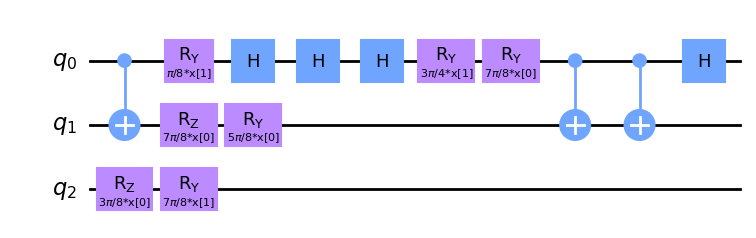

In [9]:
###print circuit
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
qc=string_to_circuit(solution,M,x_len)[0]
(qc.draw(output='mpl'))


In [10]:
###Compute accuracy metrics
svm = SVC(kernel=get_exact_kernel(qc)).fit(train_x, train_y)
train_predictions = svm.predict(train_x)
acc1 = accuracy_score(train_predictions, train_y)
test_predictions = svm.predict(test_x)
acc2 = accuracy_score(test_predictions, test_y)
print(acc1,acc2)

0.99 0.99


In [25]:
###Sample the plane for predictions
A=np.zeros((100,100))
for i,x in enumerate(np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)):
    for j,y in enumerate(np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)):
        A[i][j]=svm.predict([[x,y]])[0]
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, 'x1')

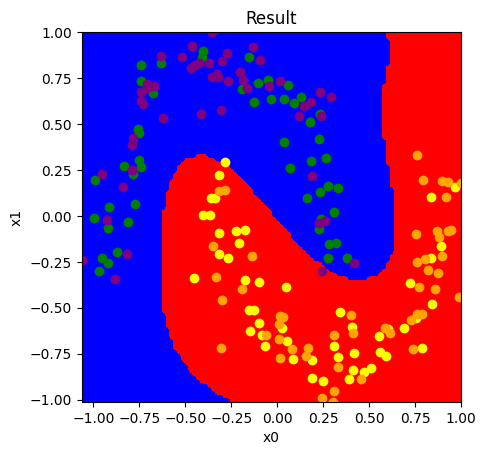

In [27]:
###Plot the results
from matplotlib import colors
%matplotlib inline
cmap = colors.ListedColormap(['blue','red'])
bounds=[-1,0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(A.T,cmap=cmap,interpolation='gaussian',norm=norm,extent=[np.min(X[:,0]),np.max(X[:,0]),np.min(X[:,1]),np.max(X[:,1])],origin='lower')

X_plus  = np.array([train_x[i] for i in range(len(train_y)) if train_y[i]==1])
X_minus  = np.array([train_x[i] for i in range(len(train_y)) if train_y[i]==-1])
plt.scatter(X_plus.T[0],X_plus.T[1],color='yellow')
plt.scatter(X_minus.T[0],X_minus.T[1],color='green')

X_plus  = np.array([test_x[i] for i in range(len(test_y)) if test_y[i]==1])
X_minus  = np.array([test_x[i] for i in range(len(test_y)) if test_y[i]==-1])
plt.scatter(X_plus.T[0],X_plus.T[1],color='orange')
plt.scatter(X_minus.T[0],X_minus.T[1],color='purple')
plt.title('Result')
plt.xlabel("x0")
plt.ylabel("x1")